In [2]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import torch 
import torch as th
import numpy as np
import pandas as pd
import pickle as pkl
from os.path import join
import matplotlib.pylab as plt
import seaborn as sns
from tqdm.auto import trange, tqdm
# from core import get_full_hessian, hessian_compute, save_imgrid, show_imgrid, plot_spectra
from circuit_toolkit.GAN_utils import BigGAN_wrapper, loadBigGAN, upconvGAN
from circuit_toolkit.plot_utils import saveallforms
from pytorch_pretrained_biggan import BigGAN

In [4]:
save_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/GAN_Hessian"
FC6_dir = join(save_root, "DeePSim_FC6")
BigGAN_dir = join(save_root, "BigGAN")
syndir = join(save_root, "synopsis")
os.makedirs(syndir, exist_ok=True)

In [5]:
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/GAN_Hessian/synopsis"
os.makedirs(figdir, exist_ok=True)

In [ ]:
DP_eigval_arr = np.load(join(syndir, "DeePSim_FC6_eigval_arr.npy"))
BigGAN_eigval_arr = np.load(join(syndir, "BigGAN_eigval_arr.npy"))

### BigGAN null space

In [10]:
# eigval_col = []
for rnd in range(1):
    for cls_id in trange(1000):
        pkl_file = join(BigGAN_dir, f"Hessian_MSE_cls{cls_id}_rnd{rnd}.pkl")
        with open(pkl_file, 'rb') as file:
            data = pkl.load(file)
        vector = data["vector"]
        H_MSE = data["H_MSE"]
        eigvec_MSE = data["eigvects_MSE"]
        eigval_MSE = data["eigvals_MSE"]
        if sum(eigval_MSE <= 0) > 0:
            print(f"cls{cls_id} rnd{rnd} has zero eigval N={sum(eigval_MSE <= 0)}")
            break
        # eigval_col.append(th.from_numpy(H_MSE))
# BigGAN_eigval_arr = th.stack(eigval_col, dim=0)
# BigGAN_eigval_arr_avg = BigGAN_eigval_arr.mean(dim=0)
# del eigval_col
# BigGAN_eigval_arr_avg_symm = (BigGAN_eigval_arr_avg + BigGAN_eigval_arr_avg.T) / 2
# BigGAN_avg_eigval, BigGAN_avg_eigvec = th.linalg.eigh(BigGAN_eigval_arr_avg_symm.cuda())
# BigGAN_avg_eigval = BigGAN_avg_eigval.cpu()
# BigGAN_avg_eigvec = BigGAN_avg_eigvec.cpu()

  0%|          | 0/1000 [00:00<?, ?it/s]

cls21 rnd0 has zero eigval N=33


In [12]:
null_eigvecs = eigvec_MSE[:, eigval_MSE <= 0]
null_eigvals = eigval_MSE[eigval_MSE <= 0]

In [17]:
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid

In [15]:
BGAN = BigGAN.from_pretrained("biggan-deep-256")
BGAN.eval().cuda()
BGAN.requires_grad_(False)
G = BigGAN_wrapper(BGAN)

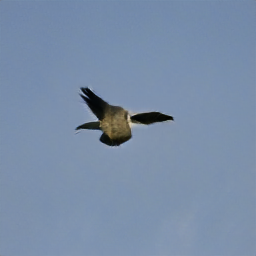

In [19]:
img = G.visualize(vector.cuda()).cpu()
to_imgrid(img)

In [23]:
vector.shape

torch.Size([1, 256])

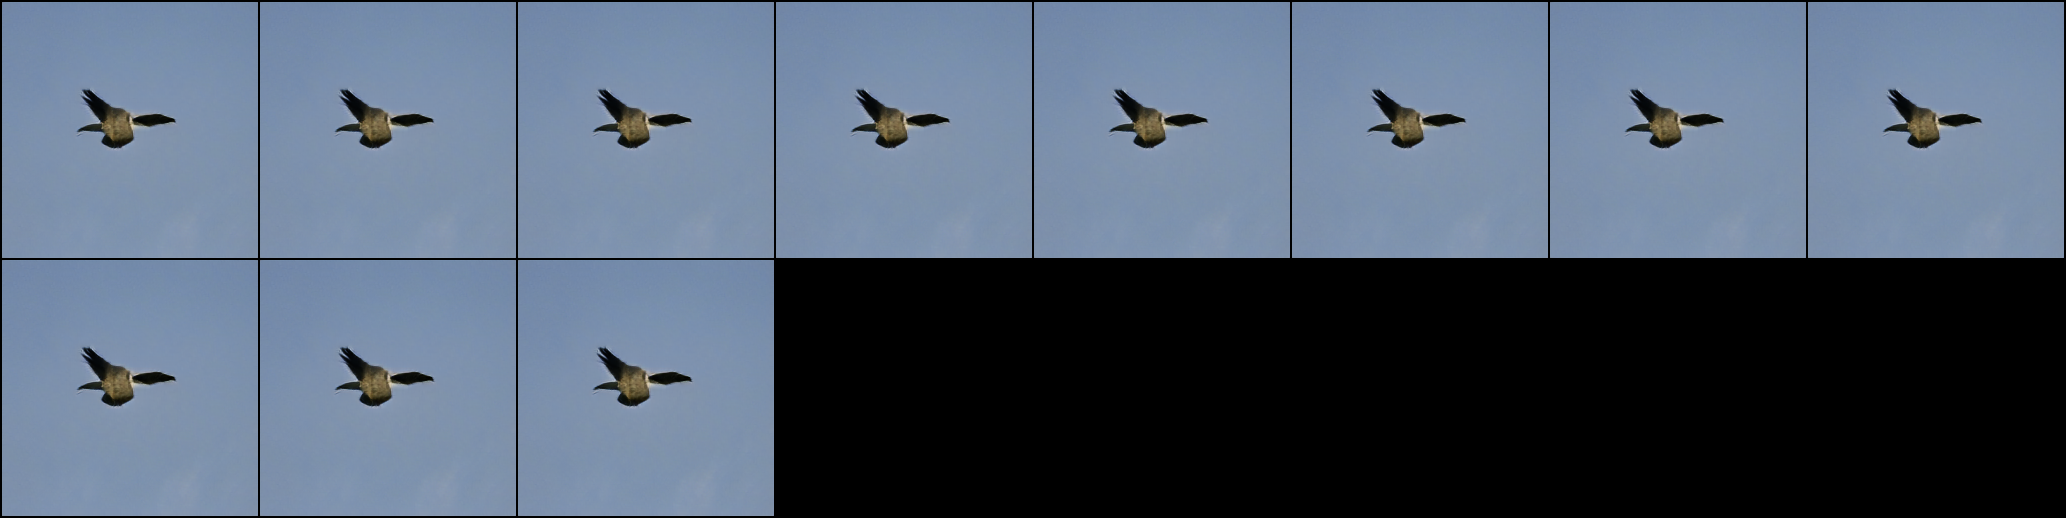

In [40]:
num_steps = 11
max_range = 1
null_vector = th.from_numpy(null_eigvecs[:, -1]).unsqueeze(0)
alphas = max_range * th.linspace(-1, 1, steps=num_steps)[:, None]
interpolated_vectors = vector + (alphas * null_vector).cuda()
imgs = G.visualize(interpolated_vectors.cuda()).cpu()
to_imgrid(imgs)

In [45]:
th.abs(imgs[1] - imgs[0]).mean()

tensor(0.0004)

In [42]:
# measure the pairwise distance between the interpolated images
dist_mat = th.cdist(imgs.flatten(start_dim=1), imgs.flatten(start_dim=1))
dist_mat.fill_diagonal_(float('inf'))
# find the minimum distance
min_dist = dist_mat.min(dim=1)
min_dist

torch.return_types.min(
values=tensor([0.4808, 0.4808, 0.4073, 0.3079, 0.3079, 0.4016, 0.4172, 0.6974, 0.6974,
        1.1186, 1.1186]),
indices=tensor([ 1,  0,  3,  4,  3,  4,  4,  8,  7, 10,  9]))

In [7]:
list(data)

['eigvals_MSE', 'eigvects_MSE', 'H_MSE', 'vector', 'class_id', 'seed']

### DeePSim null space

In [ ]:
H_col = []
for rnd in trange(1000):
    pkl_file = join(FC6_dir, f"Hessian_MSE_rnd{rnd}.pkl")
    with open(pkl_file, 'rb') as file:
        data = pkl.load(file)
    H_MSE = data["H_MSE"]
    H_col.append(th.from_numpy(H_MSE))
DP_hessian_arr = th.stack(H_col, dim=0)
DP_hessian_avg = DP_hessian_arr.mean(dim=0)